## Airbnb Price Prediction

This price prediction model is based on numerical values. Linear Regression and XGBoost will be used to generate predictions of the price parameter.

## PySpark for Big Data Models
If confronted with terabytes of data, PySpark and AWS could be used instead of pandas. A Spark cluster could be set up on AWS EMR (https://aws.amazon.com/de/emr/). 

In PySpark, Spark dataframes are used instead of pandas dataframes. This object is similar to a pandas dataframe with the difference that this kind of table is distributed across a cluster. Although it is possible to load pandas dataframes in pyspark, this should be avoided when working with big data, because it pulls the entire object into memory on a single node. The cluster architecture is useless then.

Another key difference between Pandas and Spark dataframes is eager vs lazy execution. Operations are delyed until a result is actually needed in the pipeline for PySpark. This avoids pulling the full data frame into memory and enables more effective processing across a cluster of machines. 
In Pandas dataframes, everything is pulled into memory and every operation is immediately applied.

In [1]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
#from pandana.loaders import osm
#from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# Import for NN model
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydotplus


Using TensorFlow backend.


## Import of the underlying file

In a distributed environment using AWS EMR and Pyspark, a distributed file system such as HDFS, DBFS or S3 is used to specify the path of the file.

In [2]:
listings_df = pd.read_csv(r'C:\Users\ferha\Documents\AirBnB_Price_Prediction/listings_processed.csv')

#View all columns
pd.set_option('display.max_columns', len(listings_df.columns)) 
pd.set_option('display.max_rows', 50)
listings_df.head(5)

,id,listing_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,within an hour,1.0,True,1.0,1.0,True,False,Oostelijk Havengebied - Indische Buurt,False,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,NaN,69,100.0,40.0,1,20,3,15,10,32,57,100,237,14333.0,17739.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,True,strict_14_with_grace_period,False,False,1,2.08,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,within an hour,1.0,False,1.0,1.0,True,True,Westerpark,True,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,78,300.0,40.0,2,15,2,20,0,0,0,37,40,16647.0,17720.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,False,moderate,False,False,1,1.09,7,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,within a few hours,1.0,False,2.0,2.0,True,False,Centrum-Oost,True,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,NaN,80,NaN,NaN,2,0,1,1000,0,3,28,103,215,14670.0,17747.0,87.0,9.0,10.0,9.0,9.0,10.0,9.0,False,strict_14_with_grace_period,False,False,2,2.09,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,within a few hours,1.0,False,2.0,2.0,True,False,Centrum-West,False,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,NaN,125,300.0,40.0,2,10,14,60,0,1,1,99,1,17552.0,17552.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict_14_with_grace_period,False,False,2,0.15,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,within an hour,1.0,True,1.0,1.0,True,True,Centrum-West,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,150,0.0,0.0,1,0,2,730,8,12,29,187,154,15348.0,17746.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,True,strict_14_with_grace_period,False,False,1,1.92,0,False

### Convert Boolean Values to 0 and 1 to include them in our numerical model

In [3]:
listings_df=listings_df*1
listings_df.head(5)

,id,listing_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,within an hour,1.0,1,1.0,1.0,1,0,Oostelijk Havengebied - Indische Buurt,0,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,NaN,69,100.0,40.0,1,20,3,15,10,32,57,100,237,14333.0,17739.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,0,1,2.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,within an hour,1.0,0,1.0,1.0,1,1,Westerpark,1,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,78,300.0,40.0,2,15,2,20,0,0,0,37,40,16647.0,17720.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,0,moderate,0,0,1,1.09,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,within a few hours,1.0,0,2.0,2.0,1,0,Centrum-Oost,1,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,NaN,80,NaN,NaN,2,0,1,1000,0,3,28,103,215,14670.0,17747.0,87.0,9.0,10.0,9.0,9.0,10.0,9.0,0,strict_14_with_grace_period,0,0,2,2.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,within a few hours,1.0,0,2.0,2.0,1,0,Centrum-West,0,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,NaN,125,300.0,40.0,2,10,14,60,0,1,1,99,1,17552.0,17552.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,0,0,2,0.15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,within an hour,1.0,1,1.0,1.0,1,1,Centrum-West,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,150,0.0,0.0,1,0,2,730,8,12,29,187,154,15348.0,17746.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,0,1,1.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0


### Convert room type, shared room = 0, private room = 1, entire room = 2

This can be done, because shared rooms are cheaper than private rooms that are cheaper than and entire room (when median prices are compared, see the graph at the EDA part).

In [4]:
listings_df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [5]:
# direkt als int abspeichern
listings_df.loc[listings_df.room_type == "Shared room", "room_type"] = 0
listings_df.loc[listings_df.room_type == "Private room", "room_type"] = 1
listings_df.loc[listings_df.room_type == "Entire home/apt", "room_type"] = 2

In [6]:
listings_df

,id,listing_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,within an hour,1.00,1,1.0,1.0,1,0,Oostelijk Havengebied - Indische Buurt,0,Apartment,1,2,1.5,1.0,2.0,Real Bed,NaN,69,100.0,40.0,1,20,3,15,10,32,57,100,237,14333.0,17739.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,1,strict_14_with_grace_period,0,0,1,2.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,within an hour,1.00,0,1.0,1.0,1,1,Westerpark,1,Apartment,2,5,1.0,2.0,2.0,Real Bed,NaN,78,300.0,40.0,2,15,2,20,0,0,0,37,40,16647.0,17720.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,0,moderate,0,0,1,1.09,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,within a few hours,1.00,0,2.0,2.0,1,0,Centrum-Oost,1,Townhouse,1,2,1.0,1.0,1.0,Real Bed,NaN,80,NaN,NaN,2,0,1,1000,0,3,28,103,215,14670.0,17747.0,87.0,9.0,10.0,9.0,9.0,10.0,9.0,0,strict_14_with_grace_period,0,0,2,2.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,within a few hours,1.00,0,2.0,2.0,1,0,Centrum-West,0,Apartment,2,3,1.0,1.0,1.0,Real Bed,NaN,125,300.0,40.0,2,10,14,60,0,1,1,99,1,17552.0,17552.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,0,0,2,0.15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,within an hour,1.00,1,1.0,1.0,1,1,Centrum-West,1,Apartment,1,2,1.0,1.0,1.0,Real Bed,NaN,150,0.0,0.0,1,0,2,730,8,12,29,187,154,15348.0,17746.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,0,1,1.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20109,27558661,https://www.airbnb.com/rooms/27558661,206595169,17744.0,NaN,NaN,0,3.0,3.0,1,0,Watergraafsmeer,1,Guest suite,1,2,1.0,1.0,1.0,Real Bed,NaN,58,NaN,NaN,1,0,1,1125,26,56,86,361,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,0,0,3,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2

### Delete columns with mostly nan values, Imputer could be used as well

In [7]:
listings_df.isna().mean()[listings_df.isna().mean()>0].sort_values(ascending=False)

square_feet                    0.978970
host_response_time             0.349210
host_response_rate             0.349210
security_deposit               0.313811
cleaning_fee                   0.180173
review_scores_value            0.136373
review_scores_checkin          0.136373
review_scores_location         0.136323
review_scores_communication    0.135677
review_scores_accuracy         0.135677
review_scores_cleanliness      0.135478
review_scores_rating           0.134881
reviews_per_month              0.121557
first_review                   0.121557
last_review                    0.121458
bathrooms                      0.000447
bedrooms                       0.000348
beds                           0.000298
host_identity_verified         0.000249
host_has_profile_pic           0.000249
host_total_listings_count      0.000249
host_listings_count            0.000249
host_is_superhost              0.000249
host_since                     0.000249
dtype: float64

In [8]:
# Drop Square feet and fill other columns with nan values with mean values
# unter 1% rausschmeißen (rows)
listings_df.drop(['square_feet'], axis=1, inplace=True)

In [9]:
listings_df.fillna(listings_df.mean())

,id,listing_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,within an hour,1.000000,1.0,1.0,1.0,1.0,0.0,Oostelijk Havengebied - Indische Buurt,0,Apartment,1,2,1.5,1.0,2.0,Real Bed,69,100.000000,40.000000,1,20,3,15,10,32,57,100,237,14333.000000,17739.000000,97.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,1,strict_14_with_grace_period,0,0,1,2.080000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,within an hour,1.000000,0.0,1.0,1.0,1.0,1.0,Westerpark,1,Apartment,2,5,1.0,2.0,2.0,Real Bed,78,300.000000,40.000000,2,15,2,20,0,0,0,37,40,16647.000000,17720.000000,95.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0,moderate,0,0,1,1.090000,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,within a few hours,1.000000,0.0,2.0,2.0,1.0,0.0,Centrum-Oost,1,Townhouse,1,2,1.0,1.0,1.0,Real Bed,80,218.922185,38.914554,2,0,1,1000,0,3,28,103,215,14670.000000,17747.000000,87.000000,9.000000,10.000000,9.000000,9.000000,10.000000,9.000000,0,strict_14_with_grace_period,0,0,2,2.090000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,within a few hours,1.000000,0.0,2.0,2.0,1.0,0.0,Centrum-West,0,Apartment,2,3,1.0,1.0,1.0,Real Bed,125,300.000000,40.000000,2,10,14,60,0,1,1,99,1,17552.000000,17552.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0,strict_14_with_grace_period,0,0,2,0.150000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,within an hour,1.000000,1.0,1.0,1.0,1.0,1.0,Centrum-West,1,Apartment,1,2,1.0,1.0,1.0,Real Bed,150,0.000000,0.000000,1,0,2,730,8,12,29,187,154,15348.000000,17746.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1,strict_14_with_grace_period,0,0,1,1.920000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20109,2

In [10]:
# Columns with text values
pd.options.display.max_rows = 999
listings_df.isna().sum().sort_values(ascending=False)

host_response_time                                   7024
host_response_rate                                   7024
security_deposit                                     6312
cleaning_fee                                         3624
review_scores_checkin                                2743
review_scores_value                                  2743
review_scores_location                               2742
review_scores_communication                          2729
review_scores_accuracy                               2729
review_scores_cleanliness                            2725
review_scores_rating                                 2713
first_review                                         2445
reviews_per_month                                    2445
last_review                                          2443
bathrooms                                               9
bedrooms                                                7
beds                                                    6
host_identity_

Delete columns with 2k+ na values - Delete rows of <10 na values

In [11]:
# Drop columns with >=10% nan values
listings_df = listings_df.loc[:, listings_df.isnull().mean() <= .1]

In [12]:
# Columns with text values
pd.options.display.max_rows = 999
listings_df.isna().sum().sort_values(ascending=False)

bathrooms                                            9
bedrooms                                             7
beds                                                 6
host_since                                           5
host_is_superhost                                    5
host_listings_count                                  5
host_total_listings_count                            5
host_has_profile_pic                                 5
host_identity_verified                               5
availability_90                                      0
maximum_nights                                       0
availability_30                                      0
availability_60                                      0
cancellation_policy                                  0
availability_365                                     0
number_of_reviews                                    0
instant_bookable                                     0
extra_people                                         0
require_gu

In [13]:
# delete rows where the othere nan values appear
listings_df=listings_df.dropna(axis=0, how='any')

In [14]:
listings_df

,id,listing_url,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,1,1.0,1.0,1,0,Oostelijk Havengebied - Indische Buurt,0,Apartment,1,2,1.5,1.0,2.0,Real Bed,69,1,20,3,15,10,32,57,100,237,1,strict_14_with_grace_period,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,0,1.0,1.0,1,1,Westerpark,1,Apartment,2,5,1.0,2.0,2.0,Real Bed,78,2,15,2,20,0,0,0,37,40,0,moderate,0,0,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,0,2.0,2.0,1,0,Centrum-Oost,1,Townhouse,1,2,1.0,1.0,1.0,Real Bed,80,2,0,1,1000,0,3,28,103,215,0,strict_14_with_grace_period,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,0,2.0,2.0,1,0,Centrum-West,0,Apartment,2,3,1.0,1.0,1.0,Real Bed,125,2,10,14,60,0,1,1,99,1,0,strict_14_with_grace_period,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,1,1.0,1.0,1,1,Centrum-West,1,Apartment,1,2,1.0,1.0,1.0,Real Bed,150,1,0,2,730,8,12,29,187,154,1,strict_14_with_grace_period,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20109,27558661,https://www.airbnb.com/rooms/27558661,206595169,17744.0,0,3.0,3.0,1,0,Watergraafsmeer,1,Guest suite,1,2,1.0,1.0,1.0,Real Bed,58,1,0,1,1125,26,56,86,361,0,1,flexible,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
20110,27560059,https://www.airbnb.com/rooms/27560059,206111729,17742.0,0,5.0,5.0,1,0,Centrum-West,0,Boat,1,2,1.0,1.0,2.0,Real Bed,119,1,0,3,1125,5,30,30,30,0,1,moderate,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
20111,27560295,https://www.airbnb.com/rooms/27560295,84454553,17000.0,0,7.0,7.0,1,0,Noord-West,1,House,2,4,1.0,3.0,3.0,Real Bed,159,1,0,2,1125,17,17,17,17,0,0,moderate,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0
20112,27562137,https://www.airbnb.com/rooms/27562137,58495709,16843.0,0,2.0,2.0,1,0,Centrum-West,0,Boat,2,6,2.0,3.0,6.0,Real Bed,149,2,50,3,1125,0,5,35,310,0,1,flexible,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0


In [15]:
#!!!!!!!!1 eventuell mit "most-frequent imputen damit nicht zu viele infos gelöscht werden"
# delete other text based columns, as natural language processing is not used in this model - all string based columns will be dropped
# Assumption: New data will be in the same neighborhood as given in the excel sheet, or several DFs should be created, one per neighbourhood?

In [16]:
listings_df.drop(['id', 'host_id', 'listing_url', 'property_type', 
         'bed_type', 'cancellation_policy'], axis=1, inplace=True)

In [17]:
listings_df.head()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,14146.0,1,1.0,1.0,1,0,Oostelijk Havengebied - Indische Buurt,0,1,2,1.5,1.0,2.0,69,1,20,3,15,10,32,57,100,237,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,14176.0,0,1.0,1.0,1,1,Westerpark,1,2,5,1.0,2.0,2.0,78,2,15,2,20,0,0,0,37,40,0,0,0,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
2,14580.0,0,2.0,2.0,1,0,Centrum-Oost,1,1,2,1.0,1.0,1.0,80,2,0,1,1000,0,3,28,103,215,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,14568.0,0,2.0,2.0,1,0,Centrum-West,0,2,3,1.0,1.0,1.0,125,2,10,14,60,0,1,1,99,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4,14691.0,1,1.0,1.0,1,1,Centrum-West,1,1,2,1.0,1.0,1.0,150,1,0,2,730,8,12,29,187,154,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0


In [18]:
# drop all columns with one value
listings_df.nunique()[listings_df.nunique()==1].index.tolist()

['amenity_heating',
 'amenity_kitchen',
 'amenity_tv',
 'amenity_smoke_detector',
 'amenity_hangers',
 'amenity_laptop_friendly_workspace',
 'amenity_iron',
 'amenity_shampoo',
 'amenity_hair_dryer',
 'amenity_family_kid_friendly',
 'amenity_fire_extinguisher',
 'amenity_hot_water',
 'amenity_internet',
 'amenity_cable_tv',
 'amenity_carbon_monoxide_detector',
 'amenity_first_aid_kit',
 'amenity_host_greets_you',
 'amenity_translation_missing_en_hosting_amenity_50',
 'amenity_private_entrance',
 'amenity_bed_linens',
 'amenity_refrigerator']

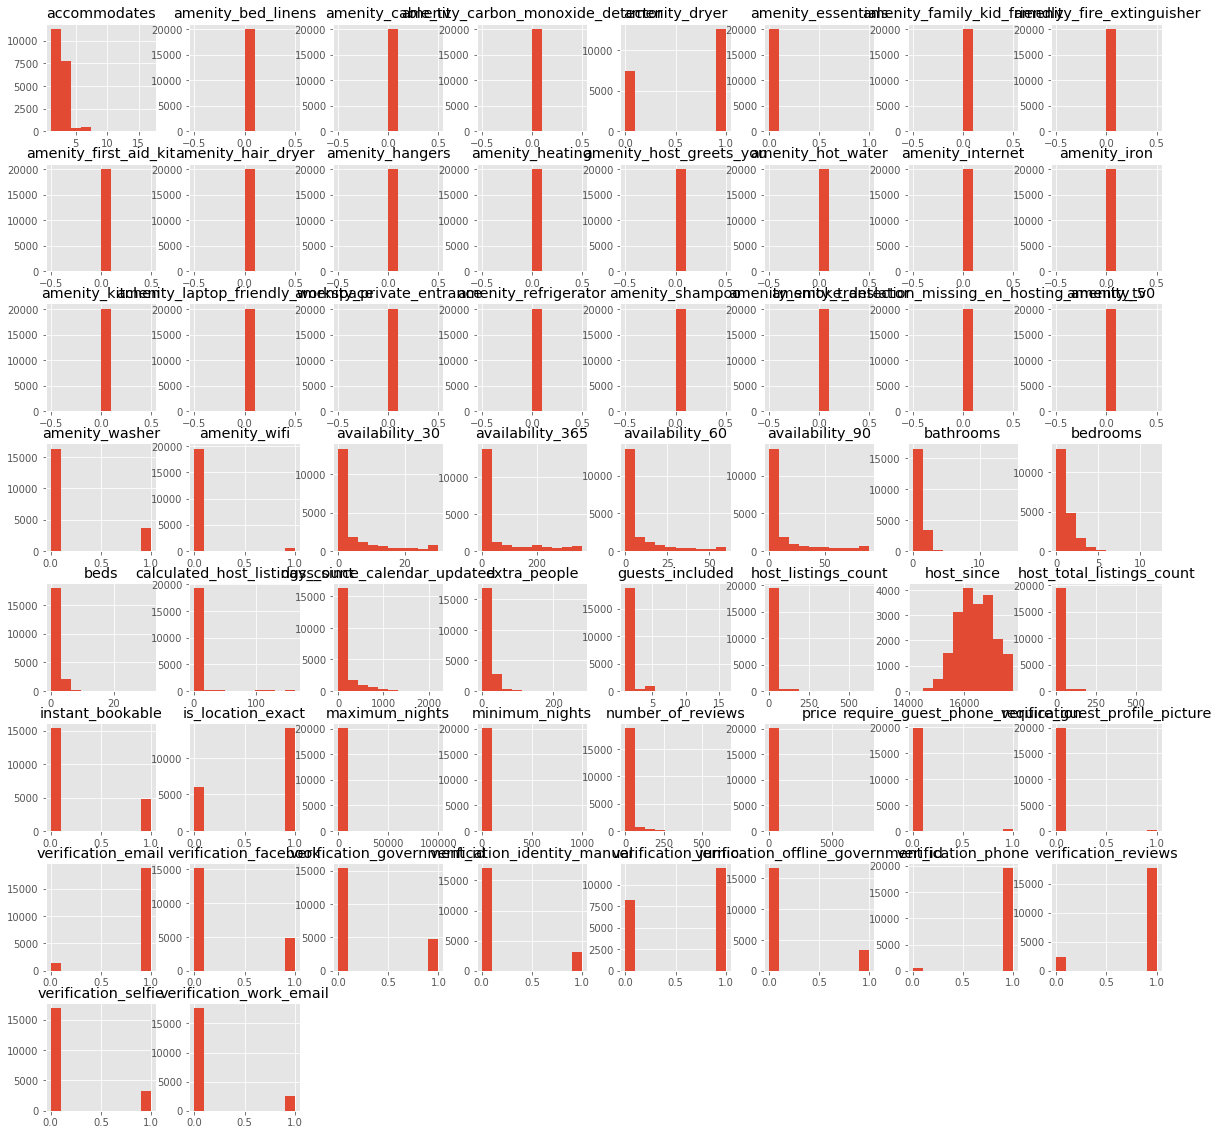

In [19]:
# Check whether boolean columns contain sufficient differences / distribution thats worth keeping them
listings_df.hist(figsize=(20,20));

In [20]:
# drop columns with only one value
listings_df.drop(listings_df.nunique()[listings_df.nunique()==1].index.tolist(), axis=1, inplace=True)

In [21]:
listings_df.head()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,days_since_calendar_updated,amenity_wifi,amenity_essentials,amenity_washer,amenity_dryer,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,14146.0,1,1.0,1.0,1,0,Oostelijk Havengebied - Indische Buurt,0,1,2,1.5,1.0,2.0,69,1,20,3,15,10,32,57,100,237,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0
1,14176.0,0,1.0,1.0,1,1,Westerpark,1,2,5,1.0,2.0,2.0,78,2,15,2,20,0,0,0,37,40,0,0,0,1,7,0,0,1,1,1,1,1,1,0,0,0,0,0,0
2,14580.0,0,2.0,2.0,1,0,Centrum-Oost,1,1,2,1.0,1.0,1.0,80,2,0,1,1000,0,3,28,103,215,0,0,0,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0
3,14568.0,0,2.0,2.0,1,0,Centrum-West,0,2,3,1.0,1.0,1.0,125,2,10,14,60,0,1,1,99,1,0,0,0,2,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0
4,14691.0,1,1.0,1.0,1,1,Centrum-West,1,1,2,1.0,1.0,1.0,150,1,0,2,730,8,12,29,187,154,1,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0


## Correlation Matrix

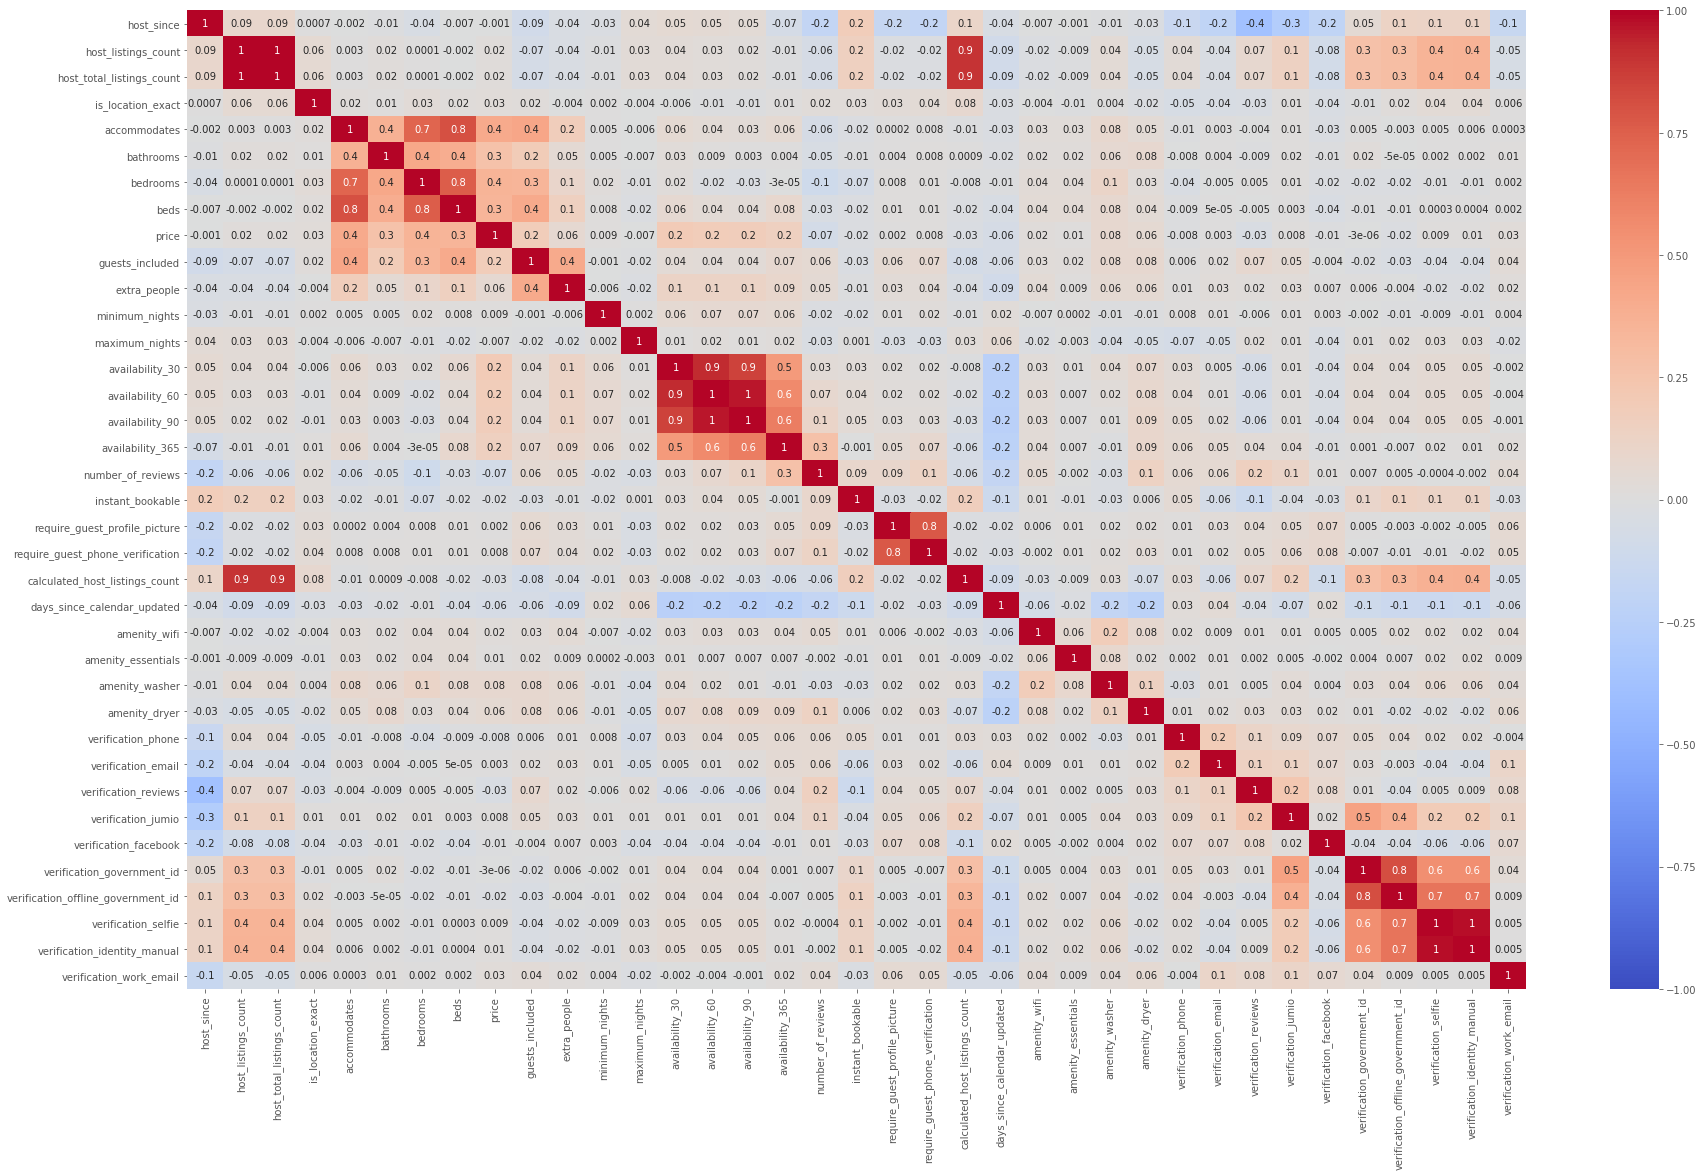

In [22]:
fig, ax = plt.subplots(figsize=(30,18))    
sns.heatmap(listings_df.corr(),annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

The following parameters have the highest correlation with the price: accommodates, bathrooms, bedrooms, beds, guests_included, availbility_30, availbility_60, availbility_90, availbility_365

## EDA - Exploratory Data Analysis

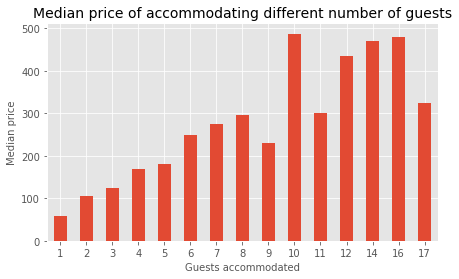

In [23]:
plt.figure(figsize=(7,4))
listings_df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of accommodating different number of guests', fontsize=14)
plt.xlabel('Guests accommodated', fontsize=10)
plt.ylabel('Median price', fontsize=10)
plt.xticks(rotation=0)
plt.show()

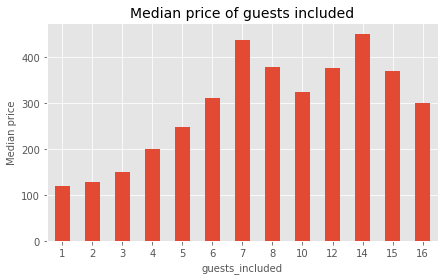

In [24]:
plt.figure(figsize=(7,4))
listings_df.groupby('guests_included').price.median().plot(kind='bar')
plt.title('Median price of guests included', fontsize=14)
plt.xlabel('guests_included', fontsize=10)
plt.ylabel('Median price', fontsize=10)
plt.xticks(rotation=0)
plt.show()

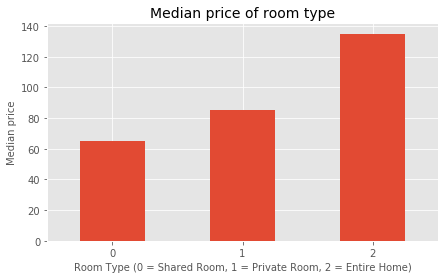

In [25]:
plt.figure(figsize=(7,4))
listings_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of room type', fontsize=14)
plt.xlabel('Room Type (0 = Shared Room, 1 = Private Room, 2 = Entire Home)', fontsize=10)
plt.ylabel('Median price', fontsize=10)
plt.xticks(rotation=0)
plt.show()

# OLS Regression - LinearRegression Scikit - Spatial Hedonic Price Model

The hedonic price theory assumes that a commodity can be viewed as an aggregation of individual attributes.

In [26]:
# use only numerical columns
listings_df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [27]:
tf_listings_df = listings_df.copy()

In [28]:
# Separate X and y, features and parameter which will be predicted
X = tf_listings_df.drop('price', axis=1)
y = tf_listings_df.price

# Scaler # Achtung: Target Leaking
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [29]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y.values.reshape(-1,1))

In [30]:
# Split to train and validation sets, 0.3 means 30% of the data is used for validation, 70% for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [31]:
# Create instance of the LinearRegression function from Scikit-Learn and fit the model on training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #train the model

# After model fit, values of the test set will be predicted:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

# Check the prediction vs actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))


Training RMSE: 0.0001
Validation RMSE: 0.0003

Training r2: 0.3056
Validation r2: 0.1628


This means our features explain between 16 and 31 % of the variance in our target variable. The RMSE measures the distance between predicted values and actual values, this value is that low because of the scaling in the previous step

In [32]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,0.016250,0.029593
1,0.039375,0.029929
2,0.025000,0.025584
3,0.021875,0.037007
4,0.012500,0.017578
...,...,...
6022,0.031250,0.022941
6023,0.016250,0.007081
6024,0.026125,0.022921
6025,1.000000,0.030363


# Gradient Boost Method - XGBRegressor

eXtreme Gradient Boosting is an implementation of gradient boosted decision trees. It is a very popular model that has recently been dominating applied machine learning for structured or tabular data. This approach supports regression and classification prediction problems, we will use it for regression obviously.

Gradient boosting itself is an approach, where new models are created that predict the residuals or errors of prior models and then added together to make a final prediction. The gradient descent algorithm algorithm is used to minimize the loss function when adding new models, therefore its called gradient boosting.

Boosting is a technique where new models are added to correct the errors which are made by existing models. The models are added sequentially until no further improvements can be made.

In [33]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.0
Validation MSE: 0.0003

Training r2: 0.8767
Validation r2: 0.1671


In [34]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
availability_60,0.089289
accommodates,0.074800
maximum_nights,0.065196
bedrooms,0.060976
verification_work_email,0.057987
minimum_nights,0.052071
bathrooms,0.050390
room_type,0.035456
availability_365,0.032726
beds,0.031185


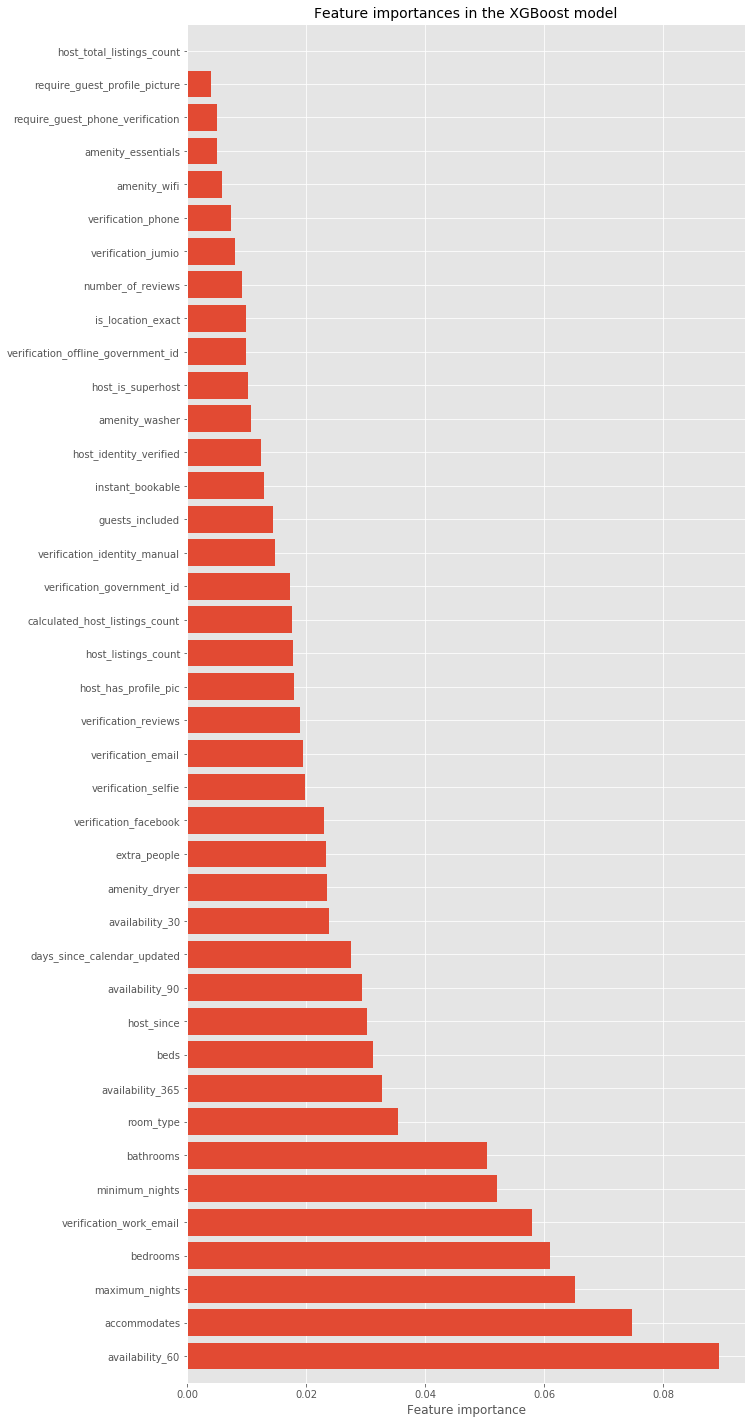

In [35]:
# Most important features
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

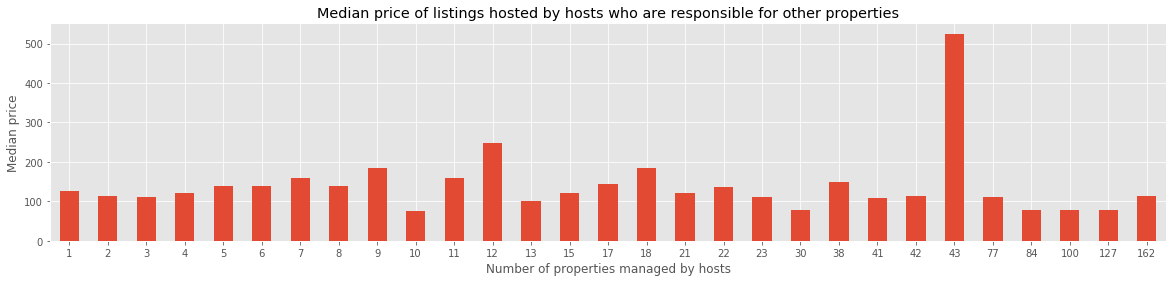

In [36]:
# Median price for different host listing counts
plt.figure()
tf_listings_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.xticks(rotation=0)
plt.ylabel('Median price');

## Improved XGB Model

In [37]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [38]:
hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))


Training RMSE: 0.0001
Validation RMSE: 0.0003

Training r2: 0.3056
Validation r2: 0.1628


In [39]:
xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))


Training MSE: 0.0
Validation MSE: 0.0003

Training r2: 0.8767
Validation r2: 0.1671


## Clean Read-In and Modelling with Pipelines

The previously shown models have some disadvantages such as no cross validation is used, also target leaking is done because the validation set also got modified before. In this alternative model, cross validation and target leaking is fixed, only the most important features according to the heatmap are used to predict the price

In [40]:
listings_df_clean = pd.read_csv(r'C:\Users\ferha\Documents\AirBnB_Price_Prediction/listings_processed.csv')

#View all columns
pd.set_option('display.max_columns', len(listings_df_clean.columns)) 
pd.set_option('display.max_rows', 50)
listings_df_clean.head(5)

,id,listing_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_since_calendar_updated,amenity_wifi,amenity_heating,amenity_essentials,amenity_kitchen,amenity_tv,amenity_smoke_detector,amenity_washer,amenity_hangers,amenity_laptop_friendly_workspace,amenity_iron,amenity_shampoo,amenity_hair_dryer,amenity_family_kid_friendly,amenity_dryer,amenity_fire_extinguisher,amenity_hot_water,amenity_internet,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_first_aid_kit,amenity_host_greets_you,amenity_translation_missing_en_hosting_amenity_50,amenity_private_entrance,amenity_bed_linens,amenity_refrigerator,verification_phone,verification_email,verification_reviews,verification_jumio,verification_facebook,verification_government_id,verification_offline_government_id,verification_selfie,verification_identity_manual,verification_work_email
0,2818,https://www.airbnb.com/rooms/2818,3159,14146.0,within an hour,1.0,True,1.0,1.0,True,False,Oostelijk Havengebied - Indische Buurt,False,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,NaN,69,100.0,40.0,1,20,3,15,10,32,57,100,237,14333.0,17739.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,True,strict_14_with_grace_period,False,False,1,2.08,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
1,3209,https://www.airbnb.com/rooms/3209,3806,14176.0,within an hour,1.0,False,1.0,1.0,True,True,Westerpark,True,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,78,300.0,40.0,2,15,2,20,0,0,0,37,40,16647.0,17720.0,95.0,10.0,9.0,10.0,10.0,9.0,9.0,False,moderate,False,False,1,1.09,7,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False
2,20168,https://www.airbnb.com/rooms/20168,59484,14580.0,within a few hours,1.0,False,2.0,2.0,True,False,Centrum-Oost,True,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,NaN,80,NaN,NaN,2,0,1,1000,0,3,28,103,215,14670.0,17747.0,87.0,9.0,10.0,9.0,9.0,10.0,9.0,False,strict_14_with_grace_period,False,False,2,2.09,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
3,25428,https://www.airbnb.com/rooms/25428,56142,14568.0,within a few hours,1.0,False,2.0,2.0,True,False,Centrum-West,False,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,NaN,125,300.0,40.0,2,10,14,60,0,1,1,99,1,17552.0,17552.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict_14_with_grace_period,False,False,2,0.15,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,27886,https://www.airbnb.com/rooms/27886,97647,14691.0,within an hour,1.0,True,1.0,1.0,True,True,Centrum-West,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,150,0.0,0.0,1,0,2,730,8,12,29,187,154,15348.0,17746.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,True,strict_14_with_grace_period,False,False,1,1.92,0,False

In [41]:
# Most important features according to correlation heatmap
features = ["accommodates", "room_type", "guests_included", "availability_30", "availability_90", "availability_365" ]

In [42]:
# encoder erstellt für jede kategorie von room_type eine neue spalte mit boolean werten für is_room_type x,y,z...
pipe = Pipeline([('encoder', OneHotEncoder(categories = 'auto', handle_unknown='ignore')),     
                ('xgb', xgb.XGBRegressor(random_state = 10))])
cv = cross_validate(estimator=pipe,X=listings_df_clean[features],y=listings_df_clean.price,\
                    scoring = 'neg_mean_absolute_error', cv=5, n_jobs=5,verbose=1) #cv=5 means 5times cross validation, varieing test and validation set, return_estimator

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.4s finished


In [43]:
cv

{'fit_time': array([2.04667234, 2.30598021, 2.06562304, 2.33290887, 2.13344073]),
 'score_time': array([0.0299201 , 0.03191543, 0.02991962, 0.0359385 , 0.02892256]),
 'test_score': array([-47.18129576, -42.07773544, -42.82988961, -45.83146988,
        -50.04994032])}

In [44]:
cv["test_score"].mean()

-45.59406620446763

In [45]:
# test score without the feature room_type array / negative mean error
np.mean([-51.28235873, -44.03715358, -45.1016255 , -48.77479057, -52.74450976])

-48.388087628

In [46]:
# encoder erstellt für jede kategorie von room_type eine neue spalte mit boolean werten für is_room_type x,y,z...
grid = {'xgb__base_score' : [0.5, 0.6, 0.7, 0.8],
       'xgb__learning_rate' : [0.05, 0.1, 0.15, 0.20, 0.25, 0.3]}

pipe = Pipeline([('encoder', OneHotEncoder(categories = 'auto', handle_unknown='ignore')),     
                ('xgb', xgb.XGBRegressor(random_state = 10))])
rs = RandomizedSearchCV(estimator=pipe, param_distributions=grid, n_iter=5, scoring = 'neg_mean_absolute_error', cv=5,verbose=1) #cv=5 means 5times cross validation, varieing test and validation set, return_estimator
rs.fit(X=listings_df_clean[features],y=listings_df_clean.price)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('encoder',
                                              OneHotEncoder(categories='auto',
                                                            drop=None,
                                                            dtype=<class 'numpy.float64'>,
                                                            handle_unknown='ignore',
                                                            sparse=True)),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,


In [47]:
rs.best_params_

{'xgb__learning_rate': 0.15, 'xgb__base_score': 0.6}

In [48]:
rs.best_estimator_['xgb']

XGBRegressor(base_score=0.6, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=10, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)